In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.stats import bootstrap
from sklearn.utils import resample
from sklearn.metrics import root_mean_squared_error
from sklearn.linear_model import LinearRegression
from agent_utils import get_world
from tqdm import tqdm
import itertools


### Colors

In [46]:
rgb_green = (17/255, 119/255, 51/255)
rgb_skyblue = (136/255, 204/255, 238/255)
rgb_magenta = (170/255, 68/255, 153/255)

# Human Data

In [47]:
df_vision = pd.read_csv("../../../data/human_data/inference/vision_judgment_rt_cleaned.csv")
df_audio = pd.read_csv("../../../data/human_data/inference/audio_judgment_rt_cleaned.csv")
df_occluded = pd.read_csv("../../../data/human_data/inference/occluded_judgment_rt_cleaned.csv")

In [48]:
worlds = df_vision["trial"].unique()

In [49]:
def get_world_index(world_number):
    """
    Returns the index of the given world_number in the worlds array.
    Raises ValueError if the world_number is not found.
    """
    idx = np.where(worlds == world_number)[0]
    if len(idx) == 0:
        raise ValueError(f"World number {world_number} not found in worlds array.")
    return idx[0]

## Data Processing

In [50]:
def compute_judge_prop(df):
    """
    Compute the proportion of each response for each trial.
    Args:
        df (pd.DataFrame): DataFrame containing trial and response columns.
    Output:
        np.ndarray: Array containing the proportion of each response for each trial.
    """
    df_grouped = df.groupby(["trial", "response"]).count().unstack(fill_value=0)
    df_prop = df_grouped.div(df_grouped.sum(axis=1), axis=0)
    return df_prop.to_numpy()

def bootstrap_prop(df, n_bootstraps=1000):
    """
    Compute bootstrap confidence intervals for response proportions.
    Args:
        df (pd.DataFrame): DataFrame containing trial and response columns.
        n_bootstraps (int): Number of bootstrap samples to generate.
    Output:
        tuple: Lower and upper bounds of the bootstrap confidence intervals.
    """
    prop_list = []
    for _ in range(n_bootstraps):
        df_resamp = resample(df, replace=True, n_samples=len(df), stratify=df["trial"])
        proportions = compute_judge_prop(df_resamp)
        prop_list.append(proportions)
    lower_bound, upper_bound = np.percentile(prop_list, [2.5, 97.5], axis=0)
    return lower_bound, upper_bound

def filter_rt(df):
    """
    Filter outliers based on the reaction time (RT) data.
    Args:
        df (pd.DataFrame): DataFrame containing trial and RT columns.
    Output:
        pd.DataFrame: DataFrame with outliers removed.
    """
    df_summary = df.groupby("trial")["rt"].agg(["mean", "std"])
    df_summary["lower_bound"] = df_summary["mean"] - 3*df_summary["std"]
    df_summary["upper_bound"] = df_summary["mean"] + 3*df_summary["std"]

    df_filtered = df.merge(df_summary, on="trial")
    df_filtered = df_filtered[(df_filtered["rt"] > df_filtered["lower_bound"]) & (df_filtered["rt"] < df_filtered["upper_bound"])]

    return df_filtered

def process_data(df_human, filter_outliers=False):
    """
    Take in raw human response df and return usable forms for further analysis.
    Args:
        df_human (pd.DataFrame): DataFrame containing raw human response data.
        filter_outliers (bool): Whether to filter outliers from the RT data.
    Output:
        tuple: Contains the following:
            - response_arr (np.ndarray): Array of responses, with NaNs replaced by -1.
            - human_prop (np.ndarray): Proportion of each response for each trial.
            - judge_lower (np.ndarray): Lower bounds of bootstrap confidence intervals for responses.
            - judge_upper (np.ndarray): Upper bounds of bootstrap confidence intervals for responses.
            - df_human_rt_summary (pd.DataFrame): Summary DataFrame containing RT statistics and confidence intervals.
    """
    df_human_judge = df_human[["participant", "trial", "response"]].copy()
    response_arr = df_human_judge.pivot_table(index="trial", columns="participant", values="response").values - 1
    response_arr = np.where(np.isnan(response_arr), -1, response_arr)
    # response_arr = response_arr.astype("Int64")
    human_prop = compute_judge_prop(df_human_judge)
    judge_lower, judge_upper = bootstrap_prop(df_human_judge)

    df_human_rt = df_human[["participant", "trial", "rt"]].copy()
    if filter_outliers:
        df_human_rt = filter_rt(df_human_rt)
    df_human_rt["log_rt"] = np.log(df_human_rt["rt"])
    df_human_rt_grouped = df_human_rt.groupby("trial")
    df_human_rt_summary = df_human_rt_grouped.agg({"rt": ["mean", "median"], "log_rt": "mean"}).reset_index()
    bootstrap_cis = [bootstrap((tr_rt["rt"].values,), np.mean, n_resamples=1000, confidence_level=0.95, method="percentile").confidence_interval for _, tr_rt in df_human_rt_grouped]
    df_human_rt_summary.columns = [f"{summary}_{measure}" if summary != "" else measure for measure, summary in df_human_rt_summary.columns.values]
    df_human_rt_summary["ci_low"] = [ci.low for ci in bootstrap_cis]
    df_human_rt_summary["ci_high"] = [ci.high for ci in bootstrap_cis]

    return response_arr, human_prop, judge_lower, judge_upper, df_human_rt_summary

def create_human_judge_df(human_prop, judge_lower, judge_upper, worlds=worlds):
    """
    Convert human proportion array into a dataframe.
    Args:
        human_prop (np.ndarray): Array of human proportions.
        judge_lower (np.ndarray): Array of lower bounds for confidence intervals.
        judge_upper (np.ndarray): Array of upper bounds for confidence intervals.
        worlds (np.ndarray): Array of world indices.
    Output:
        pd.DataFrame: DataFrame containing the human judgment data.
    """
    judge_dict = {
        "trial": np.repeat(worlds, 3),
        "hole": np.tile([0,1,2], 150),
        "data_y": human_prop.flatten(),
        "lower": judge_lower.flatten(),
        "upper": judge_upper.flatten()
    }

    return pd.DataFrame(judge_dict)

In [51]:
np.random.seed(1)
vision_response_arr, vision_human_prop, vision_judge_lower, vision_judge_upper, df_vision_rt_human = process_data(df_vision, filter_outliers=False)
audio_response_arr, audio_human_prop, audio_judge_lower, audio_judge_upper, df_audio_rt_human = process_data(df_audio, filter_outliers=False)
occluded_response_arr, occluded_human_prop, occluded_judge_lower, occluded_judge_upper, df_occluded_rt_human = process_data(df_occluded)

In [52]:
vision_response_arr = vision_response_arr.astype(int)
audio_response_arr = audio_response_arr.astype(int)
occluded_response_arr = occluded_response_arr.astype(int)

In [53]:
df_vision_judge = create_human_judge_df(vision_human_prop, vision_judge_lower, vision_judge_upper)
df_audio_judge = create_human_judge_df(audio_human_prop, audio_judge_lower, audio_judge_upper)
df_occluded_judge = create_human_judge_df(occluded_human_prop, occluded_judge_lower, occluded_judge_upper)

In [55]:
df_vision_judge.to_csv("../../../data/human_data/inference/vision_judge_summary_rt_cleaned.csv", index=False)
df_audio_judge.to_csv("../../../data/human_data/inference/audio_judge_summary_rt_cleaned.csv", index=False)
df_occluded_judge.to_csv("../../../data/human_data/inference/occluded_judge_summary_rt_cleaned.csv", index=False)

# Model Fitting

### File Processing and Data Scoring

In [10]:
def create_filename(model_type, evidence, num_samples=None, vbw=None, sbw=None, tb=None, tbw=None, beta=None, hole_select="proportional", vision_prior="uniform", audio_prior="uniform", phys_params=(0.3, 0.0, 0.7)):

    """
    Create the filename for the model with the given parameters.
    Args:
        model_type (str): Type of the model (e.g., "smart", "bandit").
        evidence (str): Type of evidence used (e.g., "visual", "auditory").
        num_samples (int, optional): Number of samples to use.
        vbw (float, optional): Visual bandwidth parameter.
        sbw (float, optional): Semantic bandwidth parameter.
        tb (float, optional): Temporal bandwidth parameter.
        tbw (float, optional): Temporal bandwidth weight parameter.
        beta (float, optional): Softmax temperature parameter.
        hole_select (str, optional): Hole selection strategy.
        vision_prior (str, optional): Vision prior distribution.
        audio_prior (str, optional): Audio prior distribution.
        phys_params (tuple, optional): Physical parameters (dn, cm, cs).
    Output:
        str: The generated filename. No extension.
    """

    dn, cm, cs = phys_params

    filename = f"{model_type}_{evidence}_"

    if model_type == "smart" or model_type == "sequential":
        filename += f"hole_select_{hole_select}_"

        if hole_select == "softmax":
            assert beta is not None
            filename += f"beta_{beta}_"

    if num_samples is not None:
        filename += f"num_samples_{num_samples}_"

    if vbw is not None:
        filename += f"bwv_{vbw}_"

    if sbw is not None:
        filename += f"bws_{sbw}_"

    if tb is not None:
        filename += f"timing_bins_{tb}_bwt_{tbw}_"

    if model_type == "bandit" or model_type == "uniform_sampler":
        filename += "prior_vision_"
    elif model_type == "mixed":
        filename += "prior_uniform_"
    elif model_type == "smart" or model_type == "sequential":
        filename += f"prior_{vision_prior}_{audio_prior}_"

    filename += f"phys_params_{dn}_{cm}_{cs}"

    return filename

def load_judge_performance(filename, path="model_performance/"):
    """
    Load the judgment performance data from CSV files.
    Args:
        filename (str): The base filename (without extension) for the judgment data.
        path (str): The base path to the model performance directory.
    Output:
        pd.DataFrame: DataFrame containing the judgment response times.
    """

    df_judge_rt = pd.read_csv(path + "judgment_rt/" + filename + ".csv")
    if "Unnamed: 0" in df_judge_rt.columns:
        df_judge_rt = df_judge_rt.drop(columns=["Unnamed: 0"])

    return df_judge_rt

def load_performance(filename, condition, path="model_performance/", cut=None):

    """
    Load the model performance for the given filename and condition.
    Args:
        filename (str): The base filename (without extension) for the performance data.
        condition (str): The specific condition to load.
        path (str): The base path to the model performance directory.
        cut (int, optional): The cut level for the performance data.
    Output:
        tuple: Contains the following:
            - df_judge_rt (pd.DataFrame): DataFrame containing the judgment response times.
            - df_emd (pd.DataFrame): DataFrame containing the EMD data.
    """

    df_judge_rt = load_judge_performance(filename, path)

    if cut is not None:
        add_str = f"_cut_{cut}"

    df_emd = pd.read_csv(path + "emd/" + filename + f"{add_str}_condition_{condition}.csv")
    if "Unnamed: 0" in df_emd.columns:
        df_emd = df_emd.drop(columns=["Unnamed: 0"])

    return df_judge_rt, df_emd


def softmax(beta, x, axis=1):
    """Compute softmax values for each sets of scores in x.
    Args:
        beta (float): Softmax temperature parameter.
        x (np.ndarray): Input array.
        axis (int): Axis along which to compute softmax.
    Output:
        np.ndarray: Softmax probabilities.
    """
    expo = np.exp(beta*x)
    return expo/np.sum(expo,axis=axis,keepdims=True)

def indiv_nll(response_arr, posterior, nan_ind):

    """
    Compute negative log likelihood for judgments on a single condition.
    Args:
        response_arr (np.ndarray): The participant response selections.
        posterior (np.ndarray): The model posterior probabilities.
        nan_ind (np.ndarray): The indices of NaN values in the response array.
    Output:
        np.ndarray: The negative log likelihood for each trial.
    """

    likelihood = posterior[np.arange(len(response_arr))[:,None], response_arr]
    likelihood[nan_ind] = np.nan
    nll = np.nansum(-np.log(likelihood), axis=1)

    return nll

def softmax_nll(beta, response_arr, posterior, nan_ind):
    """
    Compute negative log likelihood for judgments given model predictions and softmax beta.

    Args:
        beta (float): Softmax temperature parameter.
        response_arr (np.ndarray): The participant response selections.
        posterior (np.ndarray): The model posterior probabilities.
        nan_ind (np.ndarray): The indices of NaN values in the response array.
    Output:
        np.ndarray: The negative log likelihood for each trial.
    """
    
    soft_post = softmax(beta, posterior)
    nll = indiv_nll(response_arr, soft_post, nan_ind)

    return nll

def eval_comb_nll(beta, vision_response_arr, audio_response_arr, occluded_response_arr, vision_posterior, audio_posterior, occluded_posterior, vision_nan_ind, audio_nan_ind, occluded_nan_ind):
    """
    Compute the combined negative log likelihood for all conditions, given a particular softmax beta.
    Args:
        beta (float): Softmax temperature parameter.
        vision_response_arr (np.ndarray): The participant response selections for the vision condition.
        audio_response_arr (np.ndarray): The participant response selections for the audio condition.
        occluded_response_arr (np.ndarray): The participant response selections for the occluded condition.
        vision_posterior (np.ndarray): The model posterior probabilities for the vision condition.
        audio_posterior (np.ndarray): The model posterior probabilities for the audio condition.
        occluded_posterior (np.ndarray): The model posterior probabilities for the occluded condition.
        vision_nan_ind (np.ndarray): The indices of NaN values in the vision response array.
        audio_nan_ind (np.ndarray): The indices of NaN values in the audio response array.
        occluded_nan_ind (np.ndarray): The indices of NaN values in the occluded response array.
    Output:
        float: The combined negative log likelihood for all conditions.
    """
    vision_nll = softmax_nll(beta, vision_response_arr, vision_posterior, vision_nan_ind)
    audio_nll = softmax_nll(beta, audio_response_arr, audio_posterior, audio_nan_ind)
    occluded_nll = softmax_nll(beta, occluded_response_arr, occluded_posterior, occluded_nan_ind)

    return np.sum(vision_nll) + np.sum(audio_nll) + np.sum(occluded_nll)

def extract_judgments(df_model_judge):
    """
    Extract the judgment column from the model dataframe and convert it to a 2D array.
    Args:
        df_model_judge (pd.DataFrame): The model judgment dataframe.
    Output:
        np.ndarray: The extracted judgments as a 2D array.
    """
    df_model_judge_copy = df_model_judge.copy()
    df_model_judge_copy["judgment"] = df_model_judge_copy["judgment"].apply(lambda x: np.fromstring(x[1:-1], sep=","))
    # compute mean likelihood across runs for each trial
    df_model_mean = df_model_judge_copy.groupby("trial")["judgment"].apply(lambda x: np.mean(x)).reset_index()

    # concatenate all the rows of the judgment column into a 2D array
    judgment = np.stack(df_model_mean["judgment"].values)

    return judgment

def compute_judge_like_allcond(df_vision_model_judge, df_audio_model_judge, df_occluded_model_judge, vision_response_arr, audio_response_arr, occluded_response_arr, softmax_beta=False):

    """
    Compute the judgment likelihood for all conditions.
    Args:
        df_vision_model_judge (pd.DataFrame): The model judgment dataframe for the vision condition.
        df_audio_model_judge (pd.DataFrame): The model judgment dataframe for the audio condition.
        df_occluded_model_judge (pd.DataFrame): The model judgment dataframe for the occluded condition.
        vision_response_arr (np.ndarray): The participant response selections for the vision condition.
        audio_response_arr (np.ndarray): The participant response selections for the audio condition.
        occluded_response_arr (np.ndarray): The participant response selections for the occluded condition.
        softmax_beta (bool): Whether to use softmax with temperature scaling.
    Output:
        tuple: Contains the following:
            - opt_beta (float): The optimal softmax beta parameter if softmax_beta is True.
            - vision_nll (float): The negative log likelihood for the vision condition.
            - audio_nll (float): The negative log likelihood for the audio condition.
            - occluded_nll (float): The negative log likelihood for the occluded condition.
    """
    vision_post = extract_judgments(df_vision_model_judge)
    audio_post = extract_judgments(df_audio_model_judge)
    occluded_post = extract_judgments(df_occluded_model_judge)

    vision_nan_ind = np.where(vision_response_arr == -1)
    audio_nan_ind = np.where(audio_response_arr == -1)
    occluded_nan_ind = np.where(occluded_response_arr == -1)

    vision_response_arr = vision_response_arr.astype(int)
    audio_response_arr = audio_response_arr.astype(int)
    occluded_response_arr = occluded_response_arr.astype(int)

    if softmax_beta:

        optim = minimize(eval_comb_nll, 1, args=(vision_response_arr, audio_response_arr, occluded_response_arr, vision_post, audio_post, occluded_post, vision_nan_ind, audio_nan_ind, occluded_nan_ind), bounds=[(0, None)])

        opt_beta = optim["x"][0]

        vision_nll = softmax_nll(opt_beta, vision_response_arr, vision_post, vision_nan_ind)
        audio_nll = softmax_nll(opt_beta, audio_response_arr, audio_post, audio_nan_ind)
        occluded_nll = softmax_nll(opt_beta, occluded_response_arr, occluded_post, occluded_nan_ind)

    else:

        opt_beta = None

        vision_nll = indiv_nll(vision_response_arr, vision_post, vision_nan_ind)
        audio_nll = indiv_nll(audio_response_arr, audio_post, audio_nan_ind)
        occluded_nll = indiv_nll(occluded_response_arr, occluded_post, occluded_nan_ind)


    return opt_beta, vision_nll, audio_nll, occluded_nll

def compute_rt_err(df_model_rt, df_human_rt, sum_stat="mean"):
    """
    Compute the RT error between model and human responses.
    Args:
        df_model_rt (pd.DataFrame): The model RT dataframe.
        df_human_rt (pd.DataFrame): The human RT dataframe.
        sum_stat (str): The summary statistic to use ("mean", "median", or "mean_log").
    Output:
        tuple: Contains the following:
            - df_rt (pd.DataFrame): The merged dataframe with model and human RTs.
            - sq_err (np.ndarray): The squared errors between model and human RTs.
            - reg (LinearRegression): The fitted regression model.
    """
    df_model_rt = df_model_rt.copy()
    df_model_rt["log_cols"] = np.log(df_model_rt["num_cols"])
    df_model_rt = df_model_rt.groupby("trial").agg({"log_cols": "mean", "num_cols": ["mean","median"]}).reset_index()
    df_model_rt.columns = [f"{summary}_{measure}" if summary != "" else measure for measure, summary in df_model_rt.columns.values]

    if sum_stat == "mean_log":
        reg = LinearRegression().fit(df_model_rt["mean_log_cols"].values.reshape(-1, 1), df_human_rt["mean_log_rt"].values.reshape(-1, 1))
        df_model_rt["mean_log_rt_pred"] = reg.predict(df_model_rt["mean_log_cols"].values.reshape(-1, 1))
        df_rt = df_model_rt.merge(df_human_rt, on="trial")
        sq_err = (df_human_rt["mean_log_rt"] - df_model_rt["mean_log_rt_pred"])**2
    elif sum_stat == "mean":
        reg = LinearRegression().fit(df_model_rt["mean_num_cols"].values.reshape(-1, 1), df_human_rt["mean_rt"].values.reshape(-1, 1))
        df_model_rt["mean_rt_pred"] = reg.predict(df_model_rt["mean_num_cols"].values.reshape(-1, 1))
        df_rt = df_model_rt.merge(df_human_rt, on="trial")
        sq_err = (df_human_rt["mean_rt"] - df_model_rt["mean_rt_pred"])**2
    elif sum_stat == "median":
        reg = LinearRegression().fit(df_model_rt["median_num_cols"].values.reshape(-1, 1), df_human_rt["median_rt"].values.reshape(-1, 1))
        df_model_rt["median_rt_pred"] = reg.predict(df_model_rt["median_num_cols"].values.reshape(-1, 1))
        df_rt = df_model_rt.merge(df_human_rt, on="trial")
        sq_err = (df_human_rt["median_rt"] - df_model_rt["median_rt_pred"])**2
    else:
        raise Exception("sum_stat must be either mean or median")

    return df_rt, sq_err.to_numpy(), reg

def make_judge_df(fitted_judge, human_judge):

    """
    Create a dataframe for judging the model's performance against human responses.
    Args:
        fitted_judge (np.ndarray): The model's predicted responses.
        human_judge (np.ndarray): The human's actual responses.
    Output:
        pd.DataFrame: A dataframe containing the trial, hole, model_y, and human_y columns.
    """

    judge_dict = {
        "trial": [],
        "hole": [],
        "model_y": [],
        "human_y": []
    }

    for i, trial in enumerate(worlds):
        for hole in [0, 1, 2]:
            judge_dict["trial"].append(trial)
            judge_dict["hole"].append(hole)
            judge_dict["model_y"].append(fitted_judge[i, hole])
            judge_dict["human_y"].append(human_judge[i, hole])

    df_judge = pd.DataFrame(judge_dict)

    return df_judge

### Grid Work

In [11]:
def make_perf_df(model_type, vbw_range, sbw_range, beta_range=[None], softmax_beta=True, cut=None, rt_sum_stat="mean_log", hole_select="proportional", vision_prior="vision", audio_prior="uniform", audio_evidence="vision_sound_independent", inc_rt=False, phys_params=(0.3, 0.0, 0.7), model_path="model_performance/"):
    """
    Create a performance dataframe that summarizes each model's performance on each trial with each condition.
    Args:
        model_type (str): The type of model (e.g., "sequential", "uniform").
        vbw_range (list): The range of visual bandwidth values to test.
        sbw_range (list): The range of sound bandwidth values to test.
        beta_range (list, optional): The range of beta values to test.
        softmax_beta (bool, optional): Whether to apply softmax to the judgment predictions.
        cut (int, optional): The cut value for the heatmaps.
        rt_sum_stat (str, optional): The summary statistic to use for RTs.
        hole_select (str, optional): The hole selection strategy.
        vision_prior (str, optional): The vision prior distribution.
        audio_prior (str, optional): The audio prior distribution.
        audio_evidence (str, optional): The audio evidence type for the vision_sound condition.
        inc_rt (bool, optional): Whether to include RT performance in the dataframe.
        phys_params (tuple, optional): The physical parameters of the model (dn, cm, cs).
        model_path (str, optional): The path to the model performance data.
    Output:
        pd.DataFrame: The performance dataframe summarizing each model's performance.
    """
    saved_perf = {}

    if model_type == "sequential":
        perf_dict = {
            "model_type": [],
            "hole_select": [],
            "vision_prior": [],
            "audio_prior": [],
            "num_samples": [],
            "bw_vision": [],
            "bw_sound": [],
            "beta": [],
            "trial": [],
            "vision_nll": [],
            "vision_emd": [],
            "audio_nll": [],
            "audio_emd": [],
            "occluded_nll": [],
            "occluded_emd": []
        }

        params = list(itertools.product([100], vbw_range, sbw_range, beta_range))

    elif model_type == "uniform":

        perf_dict = {
            "model_type": [],
            "num_samples": [],
            "bw_vision": [],
            "bw_sound": [],
            "beta": [],
            "trial": [],
            "vision_nll": [],
            "vision_emd": [],
            "audio_nll": [],
            "audio_emd": [],
            "occluded_nll": [],
            "occluded_emd": []
        }

        params = list(itertools.product([100], vbw_range, sbw_range))

    else:
        raise Exception("model_type must be sequential or uniform")
    
    if inc_rt:
        perf_dict["vision_rt_err"] = []
        perf_dict["audio_rt_err"] = []
        perf_dict["occluded_rt_err"] = []

    for parset in tqdm(params):

        # print(parset)
        if model_type == "sequential":
            vision_params = ("vision", parset[0], parset[1], parset[3])
            occluded_params = ("occluded", parset[0], parset[2], parset[3])

            vision_filename = create_filename(model_type, "vision_independent", num_samples=parset[0], vbw=parset[1], beta=parset[2], hole_select=hole_select, vision_prior=vision_prior, audio_prior=audio_prior, phys_params=phys_params)
            audio_filename = create_filename(model_type, audio_evidence, num_samples=parset[0], vbw=parset[1], sbw=parset[2], beta=parset[3], hole_select=hole_select, vision_prior=vision_prior, audio_prior=audio_prior, phys_params=phys_params)
            occluded_filename = create_filename(model_type, "sound_independent", num_samples=parset[0], sbw=parset[2], beta=parset[3], hole_select=hole_select, vision_prior=vision_prior, audio_prior=audio_prior, phys_params=phys_params)

        elif model_type == "uniform":
            vision_params = ("vision", parset[0], parset[1])
            occluded_params = ("occluded", parset[0], parset[2])

            vision_filename = create_filename(model_type, "vision_independent", num_samples=parset[0], vbw=parset[1], phys_params=phys_params)
            audio_filename = create_filename(model_type, audio_evidence, num_samples=parset[0], vbw=parset[1], sbw=parset[2], phys_params=phys_params)
            occluded_filename = create_filename(model_type, "sound_independent", num_samples=parset[0], sbw=parset[2], phys_params=phys_params)

        else:
            raise Exception("model_type must be either smart or uniform")

        df_vision_judge_rt, df_vision_emd = load_performance(vision_filename, "vision", path=model_path, cut=cut)
        df_audio_judge_rt, df_audio_emd = load_performance(audio_filename, "audio", path=model_path, cut=cut)
        df_occluded_judge_rt, df_occluded_emd = load_performance(occluded_filename, "occluded", path=model_path, cut=cut)

        opt_beta, vision_nll, audio_nll, occluded_nll = compute_judge_like_allcond(df_vision_judge_rt, df_audio_judge_rt, df_occluded_judge_rt, vision_response_arr, audio_response_arr, occluded_response_arr, softmax_beta=softmax_beta)

        if vision_params in saved_perf:
            vision_emd = saved_perf[vision_params][0]
        else:
            vision_emd = df_vision_emd["distance"].to_numpy()

        audio_emd = df_audio_emd["distance"].to_numpy()

        if occluded_params in saved_perf:
            occluded_emd = saved_perf[occluded_params][0]
        else:
            occluded_emd = df_occluded_emd["distance"].to_numpy()

        if inc_rt:
            if vision_params in saved_perf:
                vision_sq_err = saved_perf[vision_params][1]
            else:
                _, vision_sq_err, _ = compute_rt_err(df_vision_judge_rt, df_vision_rt_human, sum_stat=rt_sum_stat)

            _, audio_sq_err, _ = compute_rt_err(df_audio_judge_rt, df_audio_rt_human, sum_stat=rt_sum_stat)

            if occluded_params in saved_perf:
                occluded_sq_err = saved_perf[occluded_params][1]
            else:
                _, occluded_sq_err, _ = compute_rt_err(df_occluded_judge_rt, df_occluded_rt_human, sum_stat=rt_sum_stat)


        perf_dict["model_type"].extend([model_type]*150)
        if model_type == "uniform":
            perf_dict["num_samples"].extend([parset[0]]*150)
            perf_dict["bw_vision"].extend([parset[1]]*150)
            perf_dict["bw_sound"].extend([parset[2]]*150)
        if model_type == "smart" or model_type == "sequential":
            perf_dict["hole_select"].extend([hole_select]*150)
            perf_dict["vision_prior"].extend([vision_prior]*150)
            perf_dict["audio_prior"].extend([audio_prior]*150)
            perf_dict["num_samples"].extend([parset[0]]*150)
            perf_dict["bw_vision"].extend([parset[1]]*150)
            perf_dict["bw_sound"].extend([parset[2]]*150)
        perf_dict["beta"].extend([parset[2] if model_type == "smart" and hole_select == "softmax" else opt_beta]*150)
        perf_dict["trial"].extend(worlds)
        perf_dict["vision_nll"].extend(vision_nll)
        perf_dict["vision_emd"].extend(vision_emd)
        perf_dict["audio_nll"].extend(audio_nll)
        perf_dict["audio_emd"].extend(audio_emd)
        perf_dict["occluded_nll"].extend(occluded_nll)
        perf_dict["occluded_emd"].extend(occluded_emd)

        if inc_rt:
            perf_dict["vision_rt_err"].extend(vision_sq_err)
            perf_dict["audio_rt_err"].extend(audio_sq_err)
            perf_dict["occluded_rt_err"].extend(occluded_sq_err)


        if vision_params not in saved_perf:
            saved_perf[vision_params] = (vision_emd, vision_sq_err if inc_rt else None)

        if occluded_params not in saved_perf:
            saved_perf[occluded_params] = (occluded_emd, occluded_sq_err if inc_rt else None)

    return pd.DataFrame(perf_dict)

def collapse_param_perf(df_perf, model_type, hole_select="proportional", inc_rt=False):

    """
    Evaluate the overall performance for each parameter setting.
    Args:
        df_perf (pd.DataFrame): The performance dataframe to evaluate.
        model_type (str): The type of model being evaluated.
        hole_select (str): The hole selection strategy.
        inc_rt (bool): Whether to include RT performance in the evaluation.
    Output:
        pd.DataFrame: The performance dataframe summarizing each model's performance.
    """
    
    if model_type == "sequential":
        if hole_select == "softmax":
            groups = ["bw_vision", "bw_sound", "beta", "hole_select", "vision_prior", "audio_prior"]
        else:
            groups = ["bw_vision", "bw_sound", "hole_select", "vision_prior", "audio_prior"]
    elif model_type == "uniform":
        groups = ["num_samples", "bw_vision", "bw_sound"]
    else:
        raise Exception("model_type must be sequential or uniform")

    if not inc_rt:
        df_perf_grouped = df_perf.groupby(groups).agg(
            vision_nll = ("vision_nll", "sum"),
            vision_emd = ("vision_emd", "mean"),
            audio_nll = ("audio_nll", "sum"),
            audio_emd = ("audio_emd", "mean"),
            occluded_nll = ("occluded_nll", "sum"),
            occluded_emd = ("occluded_emd", "mean")
        ).reset_index()

    else:
        df_perf_grouped = df_perf.groupby(groups).agg(
            vision_nll = ("vision_nll", "sum"),
            vision_rt_err = ("vision_rt_err", "mean"),
            vision_emd = ("vision_emd", "mean"),
            audio_nll = ("audio_nll", "sum"),
            audio_rt_err = ("audio_rt_err", "mean"),
            audio_emd = ("audio_emd", "mean"),
            occluded_nll = ("occluded_nll", "sum"),
            occluded_rt_err = ("occluded_rt_err", "mean"),
            occluded_emd = ("occluded_emd", "mean")
        ).reset_index()

    return df_perf_grouped

def rank_perf(df_perf, inc_rt=False):
    """
    Rank the performance of each model on all metrics and compute the average rank.
    Args:
        df_perf (pd.DataFrame): The performance dataframe to evaluate.
        inc_rt (bool): Whether to include RT performance in the evaluation.
    Output:
        pd.DataFrame: The performance dataframe with ranks added.
    """
    df_perf = df_perf.copy()
    df_perf["vision_nll_rank"] = df_perf["vision_nll"].rank()
    df_perf["vision_emd_rank"] = df_perf["vision_emd"].rank()
    df_perf["audio_nll_rank"] = df_perf["audio_nll"].rank()
    df_perf["audio_emd_rank"] = df_perf["audio_emd"].rank()
    df_perf["occluded_nll_rank"] = df_perf["occluded_nll"].rank()
    df_perf["occluded_emd_rank"] = df_perf["occluded_emd"].rank()

    if not inc_rt:
        df_perf["vision_rank"] = (df_perf["vision_nll_rank"] + df_perf["vision_emd_rank"])/2
        df_perf["audio_rank"] = (df_perf["audio_nll_rank"] + df_perf["audio_emd_rank"])/2
        df_perf["occluded_rank"] = (df_perf["occluded_nll_rank"] + df_perf["occluded_emd_rank"])/2

        df_perf["mean_rank"] = (df_perf["vision_nll_rank"] + df_perf["vision_emd_rank"] + df_perf["audio_nll_rank"] + df_perf["audio_emd_rank"] + df_perf["occluded_nll_rank"] + df_perf["occluded_emd_rank"])/6

    else:
        df_perf["vision_rt_err_rank"] = df_perf["vision_rt_err"].rank()
        df_perf["audio_rt_err_rank"] = df_perf["audio_rt_err"].rank()
        df_perf["occluded_rt_err_rank"] = df_perf["occluded_rt_err"].rank()

        df_perf["vision_rank"] = (df_perf["vision_nll_rank"] + df_perf["vision_rt_err_rank"] + df_perf["vision_emd_rank"])/3
        df_perf["audio_rank"] = (df_perf["audio_nll_rank"] + df_perf["audio_rt_err_rank"] + df_perf["audio_emd_rank"])/3
        df_perf["occluded_rank"] = (df_perf["occluded_nll_rank"] + df_perf["occluded_rt_err_rank"] + df_perf["occluded_emd_rank"])/3

        df_perf["mean_rank"] = (df_perf["vision_nll_rank"] + df_perf["vision_rt_err_rank"] + df_perf["vision_emd_rank"] + df_perf["audio_nll_rank"] + df_perf["audio_rt_err_rank"] + df_perf["audio_emd_rank"] + df_perf["occluded_nll_rank"] + df_perf["occluded_rt_err_rank"] + df_perf["occluded_emd_rank"])/9

    return df_perf

def create_model_perf_df(model_type, opt_vbw=None, opt_sbw=None, opt_beta=None, cut=None, rt_sum_stat="mean_log", hole_select="proportional", vision_prior="uniform", audio_prior="uniform", audio_evidence="vision_sound_independent", inc_rt=False, phys_params=(0.3, 0.0, 0.7)):

    """
    Create performance dataframes for the given model parameters for all signals and conditions.
    Args:
        model_type (str): The type of the model ("sequential", "uniform").
        opt_vbw (float, optional): The visual bandwidth parameter.
        opt_sbw (float, optional): The sound bandwidth parameter.
        opt_beta (float, optional): The beta parameter for softmax.
        cut (float, optional): The cutoff value for the heatmaps.
        rt_sum_stat (str, optional): The summary statistic for RT (e.g., "mean_log").
        hole_select (str, optional): The hole selection strategy (e.g., "proportional").
        vision_prior (str, optional): The vision prior distribution (e.g., "uniform").
        audio_prior (str, optional): The audio prior distribution (e.g., "uniform").
        audio_evidence (str, optional): The audio evidence type (e.g., "vision_sound_independent").
        inc_rt (bool, optional): Whether to include RT in the analysis.
        phys_params (tuple, optional): The physical parameters for the model.

    Returns:
    pd.DataFrame: A DataFrame containing the performance metrics for the model.
    """

    if model_type == "smart" or model_type == "sequential":
        vision_filename = create_filename(model_type, "vision_independent", num_samples=100, vbw=opt_vbw, beta=opt_beta, hole_select=hole_select, vision_prior=vision_prior, audio_prior=audio_prior, phys_params=phys_params)
        audio_filename = create_filename(model_type, audio_evidence, num_samples=100, vbw=opt_vbw, sbw=opt_sbw, beta=opt_beta, hole_select=hole_select, vision_prior=vision_prior, audio_prior=audio_prior, phys_params=phys_params)
        occluded_filename = create_filename(model_type, "sound_independent", num_samples=100, sbw=opt_sbw, beta=opt_beta, hole_select=hole_select, vision_prior=vision_prior, audio_prior=audio_prior, phys_params=phys_params)

    elif model_type == "uniform":
        vision_filename = create_filename(model_type, "vision_independent", num_samples=100, vbw=opt_vbw, phys_params=phys_params)
        audio_filename = create_filename(model_type, audio_evidence, num_samples=100, vbw=opt_vbw, sbw=opt_sbw, phys_params=phys_params)
        occluded_filename = create_filename(model_type, "sound_independent", num_samples=100, sbw=opt_sbw, phys_params=phys_params)

    else:
        raise Exception(f"Model type {model_type} not implemented.")

    df_vision_judge_rt, df_vision_emd = load_performance(vision_filename, "vision", cut=cut)
    df_audio_judge_rt, df_audio_emd = load_performance(audio_filename, "audio", cut=cut)
    df_occluded_judge_rt, df_occluded_emd = load_performance(occluded_filename, "occluded", cut=cut)

    vision_judge_arr = extract_judgments(df_vision_judge_rt)
    audio_judge_arr = extract_judgments(df_audio_judge_rt)
    occluded_judge_arr = extract_judgments(df_occluded_judge_rt)

    if opt_beta is None or model_type == "smart":
        fitted_vision_judge = vision_judge_arr
        fitted_audio_judge = audio_judge_arr
        fitted_occluded_judge = occluded_judge_arr
    else:
        fitted_vision_judge = softmax(opt_beta, vision_judge_arr)
        fitted_audio_judge = softmax(opt_beta, audio_judge_arr)
        fitted_occluded_judge = softmax(opt_beta, occluded_judge_arr)

    df_vision_judge = make_judge_df(fitted_vision_judge, vision_human_prop)
    df_audio_judge = make_judge_df(fitted_audio_judge, audio_human_prop)
    df_occluded_judge = make_judge_df(fitted_occluded_judge, occluded_human_prop)

    if inc_rt:
        df_vision_rt, _, _ = compute_rt_err(df_vision_judge_rt, df_vision_rt_human, sum_stat=rt_sum_stat)
        df_audio_rt, _, _ = compute_rt_err(df_audio_judge_rt, df_audio_rt_human, sum_stat=rt_sum_stat)
        df_occluded_rt, _, _ = compute_rt_err(df_occluded_judge_rt, df_occluded_rt_human, sum_stat=rt_sum_stat)

        return df_vision_judge, df_vision_rt, df_vision_emd, df_audio_judge, df_audio_rt, df_audio_emd, df_occluded_judge, df_occluded_rt, df_occluded_emd
    else:
        return df_vision_judge, df_vision_emd, df_audio_judge, df_audio_emd, df_occluded_judge, df_occluded_emd

def save_perf_dfs(perf_dfs, model_type, inc_rt=False):

    """
    Save the performance dataframes to CSV files.
    Args:
    - perf_dfs (tuple): The performance dataframes to save.
    - model_type (str): The type of the model.
    - hole_select (str, optional): The hole selection strategy.
    - vision_prior (str, optional): The vision prior distribution.
    - audio_prior (str, optional): The audio prior distribution.
    - audio_evidence (str, optional): The audio evidence type.
    - inc_rt (bool, optional): Whether to include RT data.
    Output:
    None
    """

    if not inc_rt:
        df_vision_judge, df_vision_emd, df_audio_judge, df_audio_emd, df_occluded_judge, df_occluded_emd = perf_dfs
    else:
        df_vision_judge, df_vision_rt, df_vision_emd, df_audio_judge, df_audio_rt, df_audio_emd, df_occluded_judge, df_occluded_rt, df_occluded_emd = perf_dfs
    
    path = "model_performance/top_models/"
    df_vision_judge[["trial", "hole", "model_y"]].to_csv(path + f"{model_type}_top_vision_judgment.csv", index=False)
    df_audio_judge[["trial", "hole", "model_y"]].to_csv(path + f"{model_type}_top_audio_judgment.csv", index=False)
    df_occluded_judge[["trial", "hole", "model_y"]].to_csv(path + f"{model_type}_top_occluded_judgment.csv", index=False)
    df_vision_emd.to_csv(path + f"{model_type}_top_vision_emd.csv", index=False)
    df_audio_emd.to_csv(path + f"{model_type}_top_audio_emd.csv", index=False)
    df_occluded_emd.to_csv(path + f"{model_type}_top_occluded_emd.csv", index=False)

    if inc_rt:
        df_vision_rt[["trial", "mean_num_cols", "mean_rt_pred"]].to_csv(path + f"{model_type}_top_vision_rt.csv", index=False)
        df_audio_rt[["trial", "mean_num_cols", "mean_rt_pred"]].to_csv(path + f"{model_type}_top_audio_rt.csv", index=False)
        df_occluded_rt[["trial", "mean_num_cols", "mean_rt_pred"]].to_csv(path + f"{model_type}_top_occluded_rt.csv", index=False)

# Sequential Sampler

In [12]:
model_type = "sequential"
vision_prior = "uniform"
audio_prior = "uniform"
audio_evidence = "vision_sound_independent"
vbw_range = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150]
sbw_range = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
beta_range = [None]
softmax_beta = False
hole_select = "proportional"
inc_rt = False
phys_params = (0.3, 0.0, 0.7)

In [13]:
df_perf_seq = make_perf_df(model_type, vbw_range, sbw_range, beta_range=beta_range, softmax_beta=softmax_beta, cut=300, rt_sum_stat="mean", hole_select=hole_select, vision_prior=vision_prior, audio_prior=audio_prior, audio_evidence=audio_evidence, inc_rt=inc_rt, phys_params=phys_params)

100%|██████████| 176/176 [00:03<00:00, 50.84it/s]


In [14]:
df_perf_seq_agg = collapse_param_perf(df_perf_seq, "sequential", hole_select=hole_select, inc_rt=inc_rt)
df_perf_seq_ranked = rank_perf(df_perf_seq_agg, inc_rt=inc_rt)
df_perf_seq_ranked = df_perf_seq_ranked.sort_values("mean_rank").reset_index(drop=True)
df_perf_seq_ranked

,bw_vision,bw_sound,hole_select,vision_prior,audio_prior,vision_nll,vision_emd,audio_nll,audio_emd,occluded_nll,...,vision_nll_rank,vision_emd_rank,audio_nll_rank,audio_emd_rank,occluded_nll_rank,occluded_emd_rank,vision_rank,audio_rank,occluded_rank,mean_rank
0,100,0.4,proportional,uniform,uniform,2838.862256,53.072004,2542.914115,54.442343,3080.851164,...,105.0,6.0,10.0,62.0,8.5,104.5,55.5,36.00,56.5,49.333333
1,110,0.4,proportional,uniform,uniform,2906.462859,53.117199,2536.343195,54.347534,3080.851164,...,116.0,17.0,8.0,58.0,8.5,104.5,66.5,33.00,56.5,52.000000
2,100,0.6,proportional,uniform,uniform,2838.862256,53.072004,2622.077962,53.561624,3288.562879,...,105.0,6.0,57.0,35.0,104.5,24.5,55.5,46.00,64.5,55.333333
3,90,0.4,proportional,uniform,uniform,2791.768136,53.158975,2566.157986,54.566988,3080.851164,...,94.0,28.0,31.0,66.0,8.5,104.5,61.0,48.50,56.5,55.333333
4,120,0.4,proportional,uniform,uniform,2975.320329,53.238537,2525.582920,54.330935,3080.851164,...,127.0,39.0,5.0,56.0,8.5,104.5,83.0,30.50,56.5,56.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171,0,0.1,proportional,uniform,uniform,3650.237251,67.240816,2756.742319,62.426685,3095.999667,...,171.0,171.0,119.5,175.0,64.5,152.5,171.0,147.25,108.5,142.250000
172,0,0.0,proportional,uniform,uniform,3650.237251,67.240816,2756.742319,62.426685,3095.999667,...,171.0,171.0,119.5,175.0,64.5,152.5,171.0,147.25,108.5,142.250000
173,0,0.8,proportional,uniform,uniform,3650.237251,67.240816,3007.539611,61.910591,3576.883496,...,171.0,171.0,174.0,168.0,136.5,40.5,171.0,171.00,88.5,143.500000
174,0,0.9,proportional,uniform,uniform,3650.237251,67.240816,3091.520967,62.026149,3705.898981,...,171.0,171.0,175.0,170.0,152.5,56.5,171.0,172.50,104.5,149.333333


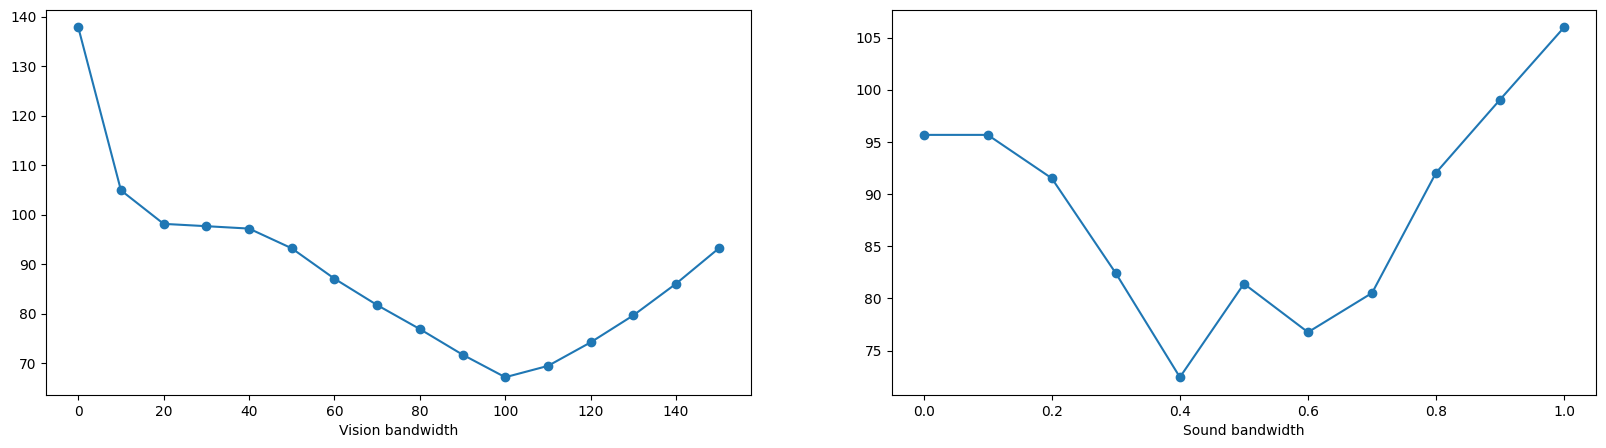

In [15]:
ave_vbw_rank = df_perf_seq_ranked.groupby("bw_vision")["mean_rank"].mean()
ave_sbw_rank = df_perf_seq_ranked.groupby("bw_sound")["mean_rank"].mean()

to_plot = [ave_vbw_rank, ave_sbw_rank]
labels = ["Vision bandwidth", "Sound bandwidth"]

_, axes = plt.subplots(1, 2, figsize=(20, 5))

for i, ax in enumerate(axes):
    ax.plot(to_plot[i])
    ax.scatter(to_plot[i].index, to_plot[i].values)
    ax.set_xlabel(labels[i])

In [16]:
opt_vbw = int(df_perf_seq_ranked.iloc[0]["bw_vision"])
opt_sbw = df_perf_seq_ranked.iloc[0]["bw_sound"]
opt_beta = None

perf_dfs = create_model_perf_df("sequential", opt_vbw=opt_vbw, opt_sbw=opt_sbw, opt_beta=opt_beta, cut=300, rt_sum_stat="mean", hole_select=hole_select, vision_prior=vision_prior, audio_prior=audio_prior, audio_evidence=audio_evidence, inc_rt=False, phys_params=(0.3, 0.0, 0.7))
save_perf_dfs(perf_dfs, model_type, inc_rt=False)

# Uniform Sampler

In [17]:
model_type = "uniform"
vbw_range = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150]
sbw_range = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
phys_params = (0.3, 0.0, 0.7)

In [18]:
df_perf_uniform = make_perf_df("uniform", vbw_range, sbw_range, softmax_beta=False, cut=300, rt_sum_stat=None, audio_evidence=audio_evidence, inc_rt=False, phys_params=phys_params, model_path="model_performance/")

100%|██████████| 176/176 [00:03<00:00, 44.82it/s]


In [19]:
df_perf_uniform_agg = collapse_param_perf(df_perf_uniform, "uniform", inc_rt=False)
df_perf_uniform_ranked = rank_perf(df_perf_uniform_agg, inc_rt=False)
df_perf_uniform_ranked = df_perf_uniform_ranked.sort_values("mean_rank").reset_index(drop=True)
df_perf_uniform_ranked

,num_samples,bw_vision,bw_sound,vision_nll,vision_emd,audio_nll,audio_emd,occluded_nll,occluded_emd,vision_nll_rank,vision_emd_rank,audio_nll_rank,audio_emd_rank,occluded_nll_rank,occluded_emd_rank,vision_rank,audio_rank,occluded_rank,mean_rank
0,100,10,0.4,2627.754716,72.459239,3000.252916,70.387752,3044.219971,44.899814,6.0,88.5,102.0,88.5,8.5,88.5,47.25,95.25,48.5,63.666667
1,100,110,0.4,2886.473812,72.459239,2616.273144,70.387752,3044.219971,44.899814,116.0,88.5,9.0,88.5,8.5,88.5,102.25,48.75,48.5,66.500000
2,100,100,0.4,2829.177307,72.459239,2663.049797,70.387752,3044.219971,44.899814,105.0,88.5,24.0,88.5,8.5,88.5,96.75,56.25,48.5,67.166667
3,100,90,0.4,2785.334633,72.459239,2723.166930,70.387752,3044.219971,44.899814,94.0,88.5,40.0,88.5,8.5,88.5,91.25,64.25,48.5,68.000000
4,100,120,0.4,2953.493957,72.459239,2581.183984,70.387752,3044.219971,44.899814,127.0,88.5,7.0,88.5,8.5,88.5,107.75,47.75,48.5,68.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171,100,140,1.0,3105.350538,72.459239,2921.580117,70.387752,3813.690445,44.899814,149.0,88.5,86.0,88.5,168.5,88.5,118.75,87.25,128.5,111.500000
172,100,0,0.8,3629.102967,72.459239,3009.829049,70.387752,3551.548303,44.899814,171.0,88.5,107.0,88.5,136.5,88.5,129.75,97.75,112.5,113.333333
173,100,150,1.0,3186.071603,72.459239,2931.713739,70.387752,3813.690445,44.899814,160.0,88.5,92.0,88.5,168.5,88.5,124.25,90.25,128.5,114.333333
174,100,0,0.9,3629.102967,72.459239,3097.081865,70.387752,3685.989110,44.899814,171.0,88.5,127.0,88.5,152.5,88.5,129.75,107.75,120.5,119.333333


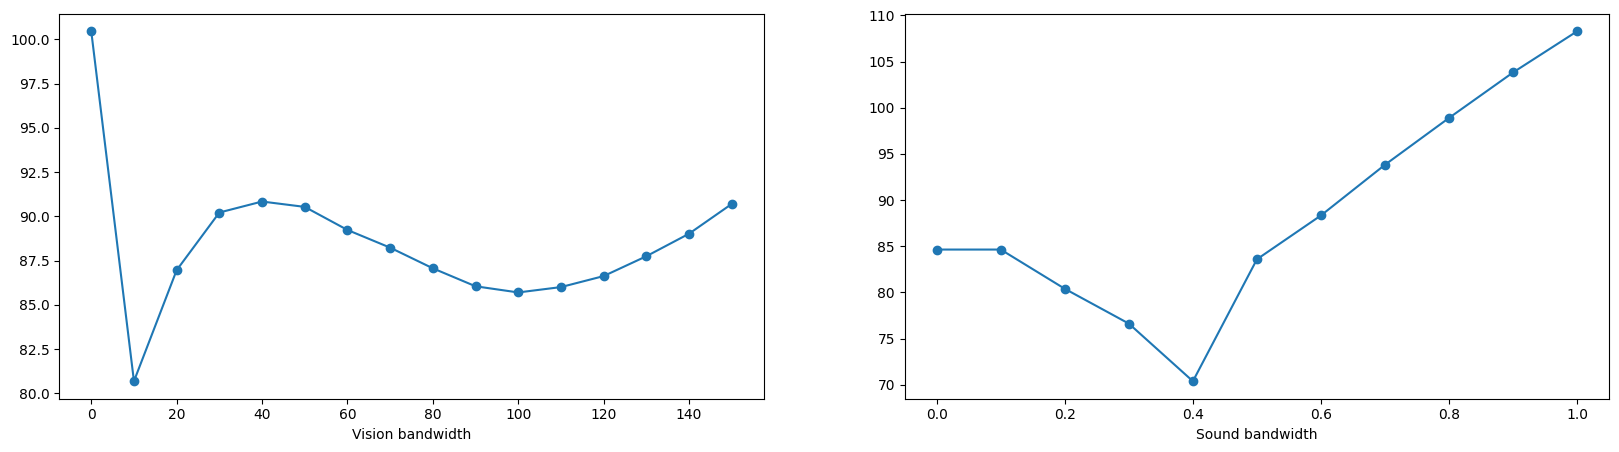

In [20]:
ave_vbw_rank = df_perf_uniform_ranked.groupby("bw_vision")["mean_rank"].mean()
ave_sbw_rank = df_perf_uniform_ranked.groupby("bw_sound")["mean_rank"].mean()

to_plot = [ave_vbw_rank, ave_sbw_rank]
labels = ["Vision bandwidth", "Sound bandwidth"]

_, axes = plt.subplots(1, 2, figsize=(20, 5))

for i, ax in enumerate(axes):
    ax.plot(to_plot[i])
    # ax.scatter(to_plot[i].idxmin(), to_plot[i].min(), color="red")
    ax.scatter(to_plot[i].index, to_plot[i].values)
    ax.set_xlabel(labels[i])

In [21]:
opt_vbw = int(df_perf_uniform_ranked.iloc[0]["bw_vision"])
opt_sbw = df_perf_uniform_ranked.iloc[0]["bw_sound"]

perf_dfs = create_model_perf_df("uniform", opt_vbw=opt_vbw, opt_sbw=opt_sbw, cut=300, rt_sum_stat="mean", audio_evidence=audio_evidence, inc_rt=False, phys_params=(0.3, 0.0, 0.7))
save_perf_dfs(perf_dfs, model_type, inc_rt=False)

### Closest Hole Heuristic

In [22]:
closest_hole_arr = np.zeros((len(worlds), 3))

for i, world_num in enumerate(worlds):
    world, _, _ = get_world(world_num)

    x_pos = world["ball_final_position_unity"]["x"]
    hole_pos = np.array(world["hole_positions_unity"])[:, 0]

    closest = np.argmin(np.abs(hole_pos - x_pos))

    closest_hole_arr[i, closest] = 1

In [23]:
def index_cha(soft_cha, response_arr):
    """
    Given the softmax closest hole array predictions and participant selections, return an array with the liklihood of each choice.
    Args:
        soft_cha (nd.array): The softmax probabilities for each choice.
        response_arr (nd.array): The participant's selected responses.
    Output:
        cha_like: (nd.array) The likelihood of each choice.
    """
    rem_judge = np.where(response_arr == -1)
    cha_like = soft_cha[np.arange(len(response_arr))[:,None], response_arr]
    cha_like[rem_judge] = np.nan

    return cha_like

def comp_cha_neg_like(beta, closest_hole_arr, vision_response_arr=vision_response_arr, audio_response_arr=audio_response_arr):
    """
    For a given softmax beta, compute the combined negative log likelihood for the closest hole heuristic in the vision and audio conditions.
    Args:
        beta (float): The softmax temperature parameter.
        closest_hole_arr (nd.array): The array indicating the closest hole for each trial.
        vision_response_arr (nd.array): The participant's selected responses for the vision condition.
        audio_response_arr (nd.array): The participant's selected responses for the audio condition.
    Output:
        float: The combined negative log likelihood.
    """
    soft_cha = softmax(beta, closest_hole_arr)

    cha_vision_like = index_cha(soft_cha, vision_response_arr)
    cha_audio_like = index_cha(soft_cha, audio_response_arr)

    comb_nll = -np.nansum(np.log(cha_vision_like)) - np.nansum(np.log(cha_audio_like))

    return comb_nll

def comp_cha_r(soft_cha, human_prop):
    return np.corrcoef(soft_cha.flatten(), human_prop.flatten())[0, 1]

def comp_cha_rmse(soft_cha, human_prop):
    return root_mean_squared_error(soft_cha.flatten()*100, human_prop.flatten()*100)

In [24]:
beta_range = np.arange(0, 5, 0.1)
cha_like = [comp_cha_neg_like(beta, closest_hole_arr) for beta in beta_range]

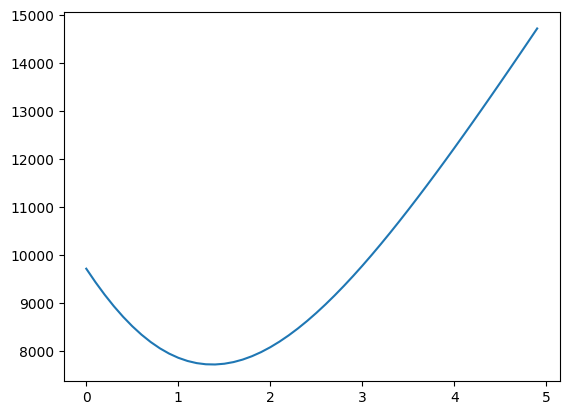

In [25]:
plt.plot(beta_range, cha_like)

In [26]:
cha_opt = minimize(comp_cha_neg_like, x0=0, args=(closest_hole_arr), bounds=((0, 5),))
cha_opt_beta = cha_opt.x[0]
cha_opt_beta

1.3703862116566903

In [27]:
cha_soft_opt = softmax(cha_opt_beta, closest_hole_arr)

In [28]:
cha_vision_r = round(np.corrcoef(cha_soft_opt.flatten(), vision_human_prop.flatten())[0, 1], 2)
cha_audio_r = round(np.corrcoef(cha_soft_opt.flatten(), audio_human_prop.flatten())[0, 1], 2)

cha_vision_rmse = round(root_mean_squared_error(cha_soft_opt.flatten()*100, vision_human_prop.flatten()*100), 2)
cha_audio_rmse = round(root_mean_squared_error(cha_soft_opt.flatten()*100, audio_human_prop.flatten()*100), 2)

print("Vision r: ", cha_vision_r)
print("Audio r: ", cha_audio_r)
print("Vision RMSE: ", cha_vision_rmse)
print("Audio RMSE: ", cha_audio_rmse)

Vision r:  0.72
Audio r:  0.57
Vision RMSE:  24.49
Audio RMSE:  29.76


# Cross-Validation

In [29]:
np.random.seed(1)
worlds_ind_perm = np.array([np.random.permutation(np.arange(150, dtype=int)) for _ in range(100)])

train_ind = np.sort(worlds_ind_perm[:, :75], axis=1)
test_ind = np.sort(worlds_ind_perm[:, 75:], axis=1)

train = worlds[train_ind]
test = worlds[test_ind]

# with open("cross_val/train.pkl", "wb") as f:
#     pickle.dump(train, f)

# with open("cross_val/test.pkl", "wb") as f:
#     pickle.dump(test, f)

In [30]:
def eval_split(df_model_perf, model_type, inc_rt=False):

    """
    Take a model performance dataframe (for a given split) and return the collapsed ranked version.
    Args:
        df_model_perf (pd.DataFrame): The model performance dataframe to evaluate.
        model_type (str): The type of model being evaluated.
        inc_rt (bool): Whether to include reaction time in the evaluation.
    Output:
        pd.DataFrame: The collapsed ranked version of the model performance dataframe.
    """

    hole_select = df_model_perf.iloc[0]["hole_select"] if model_type == "sequential" else None

    df_model_perf_agg = collapse_param_perf(df_model_perf, model_type, hole_select=hole_select, inc_rt=inc_rt)
    df_model_perf_rank = rank_perf(df_model_perf_agg, inc_rt=inc_rt)

    return df_model_perf_rank.sort_values("mean_rank").reset_index(drop=True)

def eval_test_metric(df, test_trials, metric):

    """
    For a given performance df and set of test trials, compute the given evaluation metric.
    Args:
        df (pd.DataFrame): The performance dataframe to evaluate.
        test_trials (list): The list of test trials to consider.
        metric (str): The evaluation metric to compute.
    Returns:
        float: The computed evaluation metric.
    """

    df_test = df[df["trial"].isin(test_trials)]

    if metric == "judge_r":
        return np.corrcoef(df_test["model_y"], df_test["human_y"])[0, 1]
    
    if metric == "judge_rmse":
        return root_mean_squared_error(df_test["model_y"]*100, df_test["human_y"]*100)
    
    elif metric == "rt":
        return root_mean_squared_error(df_test["mean_rt_pred"], df_test["mean_rt"])
    
    elif metric == "emd":
        return df_test["distance"].mean()
    
    else:
        raise Exception(f"Metric {metric} not implemented.")
    
def load_split_emd(split_num, model_type, parset):
    """
    This function loads the model performance data for a specific split and parameter set.
    It constructs the filename based on the model type and parameters, reads the CSV file,
    and returns the DataFrame containing the model performance data.
    
    Args:
        split_num (int): The split number to load.
        model_type (str): The type of model to load.
        parset (tuple): A tuple containing the parameters for the model.
        
    Returns:
        pd.DataFrame: A DataFrame containing the model performance data for the specified split and parameters.
    """

    evidence, vbw, sbw = parset

    filename = create_filename(model_type, evidence, num_samples=100, vbw=vbw, sbw=sbw)

    path = f"model_performance/cross_val/split{str(split_num).zfill(3)}/"
    
    return pd.read_csv(path + filename + ".csv")
    
def combine_split_emd(split_num, model_type, params):
    """
    This function creates a df of the model performance for all params in a given split.
    It loads the model performance data from the specified split and returns a DataFrame.
    Args:
        split_num (int): The split number to load.
        model_type (str): The type of model to load.
        params (list): The list of parameters to load.
    Returns:
        pd.DataFrame: A DataFrame containing the model performance data for the specified split and parameters.
    """

    emd_dict = {
        "bw_vision": [],
        "bw_sound": [],
        "trial": [],
        "vision_emd": [],
        "audio_emd": [],
        "occluded_emd": []
    }

    for parset in params:

        vbw, sbw = parset

        df_vision_emd = load_split_emd(split_num, model_type, ("vision_independent", vbw, None))
        df_audio_emd = load_split_emd(split_num, model_type, ("vision_sound_independent", vbw, sbw))
        df_occluded_emd = load_split_emd(split_num, model_type, ("sound_independent", None, sbw))

        df_vision_emd = df_vision_emd[df_vision_emd["use"] == "train"]
        df_audio_emd = df_audio_emd[df_audio_emd["use"] == "train"]
        df_occluded_emd = df_occluded_emd[df_occluded_emd["use"] == "train"]

        emd_dict["bw_vision"].extend([vbw] * len(df_vision_emd))
        emd_dict["bw_sound"].extend([sbw] * len(df_audio_emd))
        emd_dict["trial"].extend(df_vision_emd["trial"].values)
        emd_dict["vision_emd"].extend(df_vision_emd["distance"].values)
        emd_dict["audio_emd"].extend(df_audio_emd["distance"].values)
        emd_dict["occluded_emd"].extend(df_occluded_emd["distance"].values)

    return pd.DataFrame(emd_dict)
    
    
def cross_validate(model_type, train, test, params, df_model_perf, phys_params=(0.3, 0.0, 0.7)):

    """
    Run 100 split half cross-validation for the given model type (with performance df) on the train and test splits.
    Args:
        model_type (str): The type of model to evaluate.
        train (nd.array): The training splits.
        test (nd.array): The testing splits.
        params (list): The list of parameters to evaluate.
        df_model_perf (pd.DataFrame): The model performance dataframe.
        phys_params (tuple): The physical parameters for the model.
    """

    perf_dict = {
        "split": [],
        "params": [],
        "train_rank": [],
        "test_rank": [],
        "vision_judge_r": [],
        "vision_judge_rmse": [],
        "vision_emd": [],
        "audio_judge_r": [],
        "audio_judge_rmse": [],
        "audio_emd": [],
        "occluded_judge_r": [],
        "occluded_judge_rmse": [],
        "occluded_emd": []
    }

    for i in tqdm(range(len(train))):

        spl_train = train[i]
        spl_test = test[i]

        df_model_judge_train = df_model_perf[df_model_perf["trial"].isin(spl_train)].drop(columns=["vision_emd", "audio_emd", "occluded_emd"]).reset_index(drop=True)
        df_model_emd_train = combine_split_emd(i+1, model_type, params)
        df_model_train = df_model_judge_train.merge(df_model_emd_train, on=["bw_vision", "bw_sound", "trial"], how="left")

        df_train_ranked = eval_split(df_model_train, model_type)

        if model_type == "sequential":
            hole_select = df_train_ranked.iloc[0]["hole_select"]
            vision_prior = df_train_ranked.iloc[0]["vision_prior"]
            audio_prior = df_train_ranked.iloc[0]["audio_prior"]

        elif model_type == "uniform":
            hole_select = None
            vision_prior = None
            audio_prior = None

        else:
            raise Exception(f"Model type {model_type} not implemented.")

        opt_vbw = int(df_train_ranked.iloc[0]["bw_vision"])
        opt_sbw = df_train_ranked.iloc[0]["bw_sound"]

        opt_params = (opt_vbw, opt_sbw)

        df_vision_judge, _, df_audio_judge, _, df_occluded_judge, _ = create_model_perf_df(model_type,
                                                                                           opt_vbw=opt_vbw,
                                                                                           opt_sbw=opt_sbw,
                                                                                           opt_beta=None,
                                                                                           cut=300,
                                                                                           rt_sum_stat="mean",
                                                                                           hole_select=hole_select,
                                                                                           vision_prior=vision_prior,
                                                                                           audio_prior=audio_prior,
                                                                                           phys_params=phys_params)
        
        df_vision_emd = load_split_emd(i+1, model_type, ("vision_independent", opt_vbw, None))
        df_audio_emd = load_split_emd(i+1, model_type, ("vision_sound_independent", opt_vbw, opt_sbw))
        df_occluded_emd = load_split_emd(i+1, model_type, ("sound_independent", None, opt_sbw))
        
        vision_judge_r = eval_test_metric(df_vision_judge, spl_test, "judge_r")
        vision_judge_rmse = eval_test_metric(df_vision_judge, spl_test, "judge_rmse")
        vision_emd = eval_test_metric(df_vision_emd, spl_test, "emd")
        audio_judge_r = eval_test_metric(df_audio_judge, spl_test, "judge_r")
        audio_judge_rmse = eval_test_metric(df_audio_judge, spl_test, "judge_rmse")
        audio_emd = eval_test_metric(df_audio_emd, spl_test, "emd")
        occluded_judge_r = eval_test_metric(df_occluded_judge, spl_test, "judge_r")
        occluded_judge_rmse = eval_test_metric(df_occluded_judge, spl_test, "judge_rmse")
        occluded_emd = eval_test_metric(df_occluded_emd, spl_test, "emd")

        perf_dict["split"].append(i)
        perf_dict["params"].append(opt_params)
        perf_dict["train_rank"].append(df_train_ranked.iloc[0]["mean_rank"])
        perf_dict["test_rank"].append(df_train_ranked.iloc[0]["mean_rank"])
        perf_dict["vision_judge_r"].append(vision_judge_r)
        perf_dict["vision_judge_rmse"].append(vision_judge_rmse)
        perf_dict["vision_emd"].append(vision_emd)
        perf_dict["audio_judge_r"].append(audio_judge_r)
        perf_dict["audio_judge_rmse"].append(audio_judge_rmse)
        perf_dict["audio_emd"].append(audio_emd)
        perf_dict["occluded_judge_r"].append(occluded_judge_r)
        perf_dict["occluded_judge_rmse"].append(occluded_judge_rmse)
        perf_dict["occluded_emd"].append(occluded_emd)


    return pd.DataFrame(perf_dict)


def percentile_2pt5(x):
    return x.quantile(0.025)

def percentile_97pt5(x):
    return x.quantile(0.975)

def compute_cv_diff(df_main, df_comp, metric_cols):

    """
    Compute the difference scores between the splits in df_main and df_comp on the given metric columns
    Args:
        df_main (pd.DataFrame): The main DataFrame containing the first set of splits.
        df_comp (pd.DataFrame): The comparison DataFrame containing the second set of splits.
        metric_cols (list): The list of metric columns to compute the differences for.
    Output:
        pd.DataFrame: A DataFrame containing the difference scores between the splits.
    """

    df_diff = df_main[metric_cols] - df_comp[metric_cols]

    return df_diff

In [31]:
df_perf_seq

,model_type,hole_select,vision_prior,audio_prior,num_samples,bw_vision,bw_sound,beta,trial,vision_nll,vision_emd,audio_nll,audio_emd,occluded_nll,occluded_emd
0,sequential,proportional,uniform,uniform,100,0,0.0,None,1,32.835530,58.615379,24.443892,40.581032,21.141253,38.659027
1,sequential,proportional,uniform,uniform,100,0,0.0,None,2,31.872558,67.150497,22.124954,40.443768,21.542019,60.871498
2,sequential,proportional,uniform,uniform,100,0,0.0,None,3,17.397131,69.307243,0.522663,99.422401,8.763514,93.747078
3,sequential,proportional,uniform,uniform,100,0,0.0,None,4,16.604004,56.075150,4.862409,107.241432,2.564953,86.403625
4,sequential,proportional,uniform,uniform,100,0,0.0,None,5,32.096891,65.024323,22.753433,55.431622,19.773512,34.811340
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26395,sequential,proportional,uniform,uniform,100,150,1.0,None,316,15.806984,47.096310,7.645303,65.908966,26.276147,48.011818
26396,sequential,proportional,uniform,uniform,100,150,1.0,None,319,9.310251,50.754490,16.098667,44.636692,23.704685,58.035103
26397,sequential,proportional,uniform,uniform,100,150,1.0,None,326,10.154962,66.184052,22.527299,30.988718,31.535290,21.846024
26398,sequential,proportional,uniform,uniform,100,150,1.0,None,332,15.934027,66.380264,26.514092,46.850048,32.895990,54.396481


In [32]:
vbw_range = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150]
sbw_range = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

params = list(itertools.product(vbw_range, sbw_range))

In [33]:
df_cv_smart = cross_validate("sequential", train, test, params, df_perf_seq)

100%|██████████| 100/100 [00:37<00:00,  2.66it/s]


In [34]:
df_cv_smart

,split,params,train_rank,test_rank,vision_judge_r,vision_judge_rmse,vision_emd,audio_judge_r,audio_judge_rmse,audio_emd,occluded_judge_r,occluded_judge_rmse,occluded_emd
0,0,"(100, 0.4)",50.833333,50.833333,0.881928,16.743870,52.598241,0.928875,13.635856,54.235583,0.891323,15.741060,42.996407
1,1,"(100, 0.4)",47.166667,47.166667,0.890194,17.109280,52.665715,0.946884,12.260589,55.845588,0.888849,15.574303,47.598896
2,2,"(100, 0.4)",50.833333,50.833333,0.883794,16.193578,52.035829,0.936511,12.946081,53.085423,0.871262,17.230377,44.244295
3,3,"(120, 0.4)",47.666667,47.666667,0.902977,16.248546,52.909811,0.932173,13.122961,52.367428,0.880177,16.543873,44.335958
4,4,"(120, 0.4)",53.666667,53.666667,0.875298,17.960900,51.654725,0.933113,12.782259,50.915572,0.860956,16.956971,41.714912
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,95,"(100, 0.4)",44.166667,44.166667,0.887700,16.943409,51.680811,0.927537,13.902086,53.745364,0.872708,15.944240,44.994634
96,96,"(90, 0.6)",54.333333,54.333333,0.904243,15.634257,53.732764,0.934956,12.987980,56.044324,0.860991,18.609365,45.053187
97,97,"(100, 0.4)",47.833333,47.833333,0.911464,14.489165,54.033288,0.939835,12.641710,56.893904,0.891024,15.751121,44.310486
98,98,"(100, 0.4)",48.666667,48.666667,0.896029,16.119497,53.368421,0.944186,12.210993,52.940347,0.866749,16.596785,42.437165


In [35]:
metric_cols = ["vision_judge_r", "vision_judge_rmse", "vision_emd", "audio_judge_r", "audio_judge_rmse", "audio_emd", "occluded_judge_r", "occluded_judge_rmse", "occluded_emd"]

df_cv_smart_sum = df_cv_smart[metric_cols].agg(
    ["median", percentile_2pt5, percentile_97pt5]
)

df_cv_smart_sum.round(2)

,vision_judge_r,vision_judge_rmse,vision_emd,audio_judge_r,audio_judge_rmse,audio_emd,occluded_judge_r,occluded_judge_rmse,occluded_emd
median,0.89,16.58,52.94,0.94,12.79,54.06,0.87,16.89,44.47
percentile_2pt5,0.87,15.01,50.55,0.92,10.78,51.09,0.84,15.06,41.16
percentile_97pt5,0.91,18.42,55.09,0.96,14.71,57.21,0.90,19.87,48.04


In [36]:
df_cv_uniform = cross_validate("uniform", train, test, params, df_perf_uniform)

100%|██████████| 100/100 [00:36<00:00,  2.74it/s]


In [37]:
df_cv_uniform_sum = df_cv_uniform[metric_cols].agg(
    ["median", percentile_2pt5, percentile_97pt5]
)

df_cv_uniform_sum.round(2)

,vision_judge_r,vision_judge_rmse,vision_emd,audio_judge_r,audio_judge_rmse,audio_emd,occluded_judge_r,occluded_judge_rmse,occluded_emd
median,0.96,10.63,72.10,0.93,14.84,69.46,0.87,16.46,45.25
percentile_2pt5,0.90,9.43,69.56,0.91,12.93,66.29,0.85,14.89,42.16
percentile_97pt5,0.97,15.85,74.21,0.95,16.50,73.04,0.90,17.66,49.13


In [38]:
df_cv_diff = compute_cv_diff(df_cv_smart, df_cv_uniform, metric_cols)

df_cv_diff_sum = df_cv_diff[metric_cols].agg(
    ["median", percentile_2pt5, percentile_97pt5]
)

df_cv_diff_sum.round(2)

,vision_judge_r,vision_judge_rmse,vision_emd,audio_judge_r,audio_judge_rmse,audio_emd,occluded_judge_r,occluded_judge_rmse,occluded_emd
median,-0.06,5.98,-18.92,0.00,-2.26,-15.13,0.00,0.30,-0.89
percentile_2pt5,-0.09,1.08,-21.46,-0.02,-3.77,-18.11,-0.02,-0.25,-2.71
percentile_97pt5,-0.01,7.71,-16.43,0.02,0.60,-12.54,0.01,2.77,0.88


In [39]:
cha_opt_dict = {
    "split": [],
    "beta": [],
    "vision_judge_r": [],
    "vision_judge_rmse": [],
    "audio_judge_r": [],
    "audio_judge_rmse": []
}

# cha_opt_betas = []

for i in range(100):
    train_spl = train_ind[i]
    test_spl = test_ind[i]

    spl_train_cha = closest_hole_arr[train_spl]
    spl_test_cha = closest_hole_arr[test_spl]

    spl_vra = vision_response_arr[train_spl]
    spl_ara = audio_response_arr[train_spl]

    spl_vhp = vision_human_prop[test_spl]
    spl_ahp = audio_human_prop[test_spl]

    spl_opt = minimize(comp_cha_neg_like, x0=0, args=(spl_train_cha, spl_vra, spl_ara), bounds=((0, 5),))

    assert spl_opt.success

    spl_beta = spl_opt.x[0]

    spl_soft_opt = softmax(spl_beta, spl_test_cha)

    spl_vision_r = comp_cha_r(spl_soft_opt, spl_vhp)
    spl_audio_r = comp_cha_r(spl_soft_opt, spl_ahp)

    spl_vision_rmse = comp_cha_rmse(spl_soft_opt, spl_vhp)
    spl_audio_rmse = comp_cha_rmse(spl_soft_opt, spl_ahp)

    cha_opt_dict["split"].append(i)
    cha_opt_dict["beta"].append(spl_beta)
    cha_opt_dict["vision_judge_r"].append(spl_vision_r)
    cha_opt_dict["audio_judge_r"].append(spl_audio_r)
    cha_opt_dict["vision_judge_rmse"].append(spl_vision_rmse)
    cha_opt_dict["audio_judge_rmse"].append(spl_audio_rmse)


df_cv_cha = pd.DataFrame(cha_opt_dict)

In [40]:
df_cv_cha_sum = df_cv_cha[["vision_judge_r", "vision_judge_rmse", "audio_judge_r", "audio_judge_rmse"]].agg(
    ["median", percentile_2pt5, percentile_97pt5]
)

df_cv_cha_sum.round(2)

,vision_judge_r,vision_judge_rmse,audio_judge_r,audio_judge_rmse
median,0.72,24.55,0.57,29.95
percentile_2pt5,0.66,23.26,0.49,27.15
percentile_97pt5,0.79,26.35,0.66,32.39


In [41]:
df_smart_cha_diff = compute_cv_diff(df_cv_smart, df_cv_cha, ["vision_judge_r", "vision_judge_rmse", "audio_judge_r", "audio_judge_rmse"])

df_smart_cha_diff_sum = df_smart_cha_diff[["vision_judge_r", "vision_judge_rmse", "audio_judge_r", "audio_judge_rmse"]].agg(
    ["median", percentile_2pt5, percentile_97pt5]
)

df_smart_cha_diff_sum.round(2)

,vision_judge_r,vision_judge_rmse,audio_judge_r,audio_judge_rmse
median,0.17,-7.88,0.36,-17.16
percentile_2pt5,0.11,-9.75,0.29,-19.62
percentile_97pt5,0.22,-6.17,0.45,-14.72


### Visual Features Model

In [42]:
vf_cv_dict = {
    "split": [],
    "vision_emd": [],
    "audio_emd": [],
    "occluded_emd": []
}

for split in range(100):

    vf_perf = pd.read_csv(f"model_performance/cross_val/visual_features/emd_{split+1}.csv")

    vf_perf_test = vf_perf[vf_perf["use"] == "test"]

    vf_pivot = vf_perf_test.pivot(index="trial", columns="condition", values="emd").reset_index()
    vf_cv_dict["split"].append(split)
    vf_cv_dict["vision_emd"].append(vf_pivot.get("vision", np.nan).mean())
    vf_cv_dict["audio_emd"].append(vf_pivot.get("audio", np.nan).mean())
    vf_cv_dict["occluded_emd"].append(vf_pivot.get("occluded", np.nan).mean())

df_vf_cv = pd.DataFrame(vf_cv_dict)

In [43]:
emd_cols = ["vision_emd", "audio_emd", "occluded_emd"]

df_vf_cv[emd_cols].agg(
    ["median", percentile_2pt5, percentile_97pt5]
).round(2)

,vision_emd,audio_emd,occluded_emd
median,78.73,77.93,57.14
percentile_2pt5,76.43,75.19,54.29
percentile_97pt5,81.22,81.20,62.23


In [44]:
df_smart_vf_diff = compute_cv_diff(df_cv_smart, df_vf_cv, emd_cols)

df_smart_vf_diff_sum = df_smart_vf_diff[emd_cols].agg(
    ["median", percentile_2pt5, percentile_97pt5]
).round(2)

df_smart_vf_diff_sum

,vision_emd,audio_emd,occluded_emd
median,-25.76,-23.77,-13.02
percentile_2pt5,-28.39,-26.15,-15.19
percentile_97pt5,-23.20,-21.30,-10.95
